## Feature Engineering

### Dimentionality Reduction

##### In this notebook we try to find unnecessary features and remove them from data, so the model can train easier and generalize better .

##### So far we have cleaned our data and searched for best possible hyper-parameters. Results are as below:

* Result don't change if we apply standard scaler on all features (OneHotEncoded categories and continuous) or only on continous features
* **RandomForestRegressor** works better than XGBRegressor with this dataset
* Best hyper-parameters: `n_estimators`=150, `max_depth`=None, `min_samples_leaf`=2, `max_features`=0.5
* Model produces better result when DV is not transformed. So we keep the original target values.
* Best results so far: `MAE`: 1.20551, `R^2`: 0.81978
<br><br><br>


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Data and environment setup

In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [0]:
# loading libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt
import os
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA, SparsePCA
from sklearn import feature_selection

In [4]:
# setting paths
# data_dir = os.path.abspath('./_data')
data_dir = os.path.abspath('/content/drive/My Drive/Projects/YapAiTek_Challenge/_data')
train_data_fp = os.path.join(data_dir, 'train_clean_msc.csv')
test_data_fp = os.path.join(data_dir, 'test_clean_msc.csv')
data_fp = os.path.join(data_dir, 'data_clean_msc.csv')
os.listdir(data_dir)

['data.csv',
 'test.csv',
 'data_no_missing.csv',
 'train_clean.csv',
 'test_clean.csv',
 'data_clean.csv',
 'train_clean_msc.csv',
 'test_clean_msc.csv',
 'data_clean_msc.csv',
 '(old)to_keep_columns_stage1.npy',
 '.ipynb_checkpoints',
 '(old)to_keep_columns_stage2.npy',
 'to_keep_columns_stage1.npy',
 'to_keep_columns_stage2.npy']

In [5]:
# load the training set and shuffle it
train_set = pd.read_csv(train_data_fp)
train_set = train_set.sample(frac=1)
train_set.head(1)

,ch_type,length,first_or_rerun,episodes_in_season,is_movie,overlaped_with_game,temperature,Week,Day,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,running_time,episode_name_na,temperature_na,station_ARTV+,station_Canal D+,station_Canal Vie+,station_Evasion+,station_Historia+,station_LCN+,station_MAX+,station_Meteomedia+,"station_MusiquePlus+ (retired Aug 25, 2019)",station_PYC Online Stream Fr CBC-8+,station_PYC Online Stream Fr CBC-9+,station_RDI+,station_RDS+,station_RDS2+,station_SRC Total,station_Series++,station_TQ Total,station_TV5+,station_TVA Total,station_Teletoon Fr.+,...,genre_Music Video Programs,genre_Music and Dance other than Music Video Programs or Clips,genre_News,genre_Ongoing Comedy Series (Sitcoms),genre_Ongoing Dramatic Series,genre_Other Drama,genre_Professional Sports,"genre_Programs of Comedy Sketches, Improvision, Unscripted Works",genre_Reality Programs,genre_Religion,genre_Reporting and Actualities,"genre_Specials, Mini-Series or Made-for-TV Feature Films",genre_Theatre Feature Films Aired on TV,genre_Unknown,genre_Variety,Year_2016,Year_2017,Year_2018,Year_2019,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Dayofweek_0,Dayofweek_1,Dayofweek_2,Dayofweek_3,Dayofweek_4,Dayofweek_5,Dayofweek_6,market_share,market_share_transformed
177170,1,0.043478,0,1,0,0,0.582766,0.352941,0.366667,0.358904,0,0,0,0,0,0,0.234647,0.041696,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,-0.077182


In [0]:
# cut the dependant variable(s) form training set
# target = train_set.loc[:, 'market_share_transformed']
target_src = train_set.loc[:, 'market_share']
# targets_joint = train_set.loc[:, ['market_share_transformed', 'market_share']]

train_set.drop(columns=['market_share', 'market_share_transformed'], inplace=True)

In [0]:
# constant variables for later use
cv = 5    # number of folds for cross-validation
rs = 1    # random-state number
sample_size_large = 300000
sample_size_small = 35000

### Defining few helper functions

In [0]:
def get_rf_model(n_estimators=150, max_depth=None, min_samples_leaf=2, max_features=0.5, random_state=rs):
    rf = RandomForestRegressor(n_estimators=n_estimators,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               max_features=max_features,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=random_state)
    return rf

In [0]:
def evaluate(actual, prediction):
    return {'MAE': round(mean_absolute_error(actual, prediction), 5),
            'MSE': round(mean_squared_error(actual, prediction), 5),
            'R^2': round(r2_score(actual, prediction), 5)}

In [0]:
def get_oob_score(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features=0.5, oob_score=True, n_jobs=-1, random_state=rs)
    rf.fit(X_train, y_train)
    score = rf.oob_score_
    del rf
    return round(score, 5)

In [11]:
get_oob_score(train_set.iloc[:sample_size_small], target_src.iloc[:sample_size_small])

0.73146

In [0]:
def get_sample_df(X_train, y_train, n_samples=20000):
    df = pd.concat(objs=[X_train, y_train], axis=1)
    x = df.sample(n=n_samples, axis=0)
    del df
    return x.iloc[:, :-1], x.iloc[:, -1]

In [0]:
def plot_feature_importance(fi, labels, n_features=None, figsize=(14, 8)):
    nf = n_features if n_features is not None else len(fi)
    
    fi = sorted(zip(fi, labels), reverse=True)[:nf]
    d = d = {k: v for v, k in fi}
    plt.figure(figsize=figsize)
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation='vertical')
    plt.show()
    del d

In [0]:
def full_eval(rf, X_train, y_train, X_test, y_test):
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    res = evaluate(y_test, preds)
    res['oob_score'] = round(rf.oob_score_, 5)
    return res
    

### Create sample train and test sets for later analysis

In [15]:
X_train, y_train = get_sample_df(train_set, target_src, n_samples=sample_size_large)
X_train.shape, y_train.shape

((300000, 94), (300000,))

In [16]:
X_test, y_test = get_sample_df(train_set, target_src, n_samples=sample_size_small)
X_test.shape, y_test.shape

((35000, 94), (35000,))

## 1. Get the most important features

In [0]:
%%time

rf = get_rf_model()
rf.fit(X_train, y_train)

CPU times: user 10min 20s, sys: 857 ms, total: 10min 20s
Wall time: 5min 22s


In [0]:
preds = rf.predict(X_test)

print('oob_score: %.5f' % rf.oob_score_)
evaluate(y_test, preds)

oob_score: 0.80191


{'MAE': 1.01381, 'MSE': 3.07531, 'R^2': 0.86633}

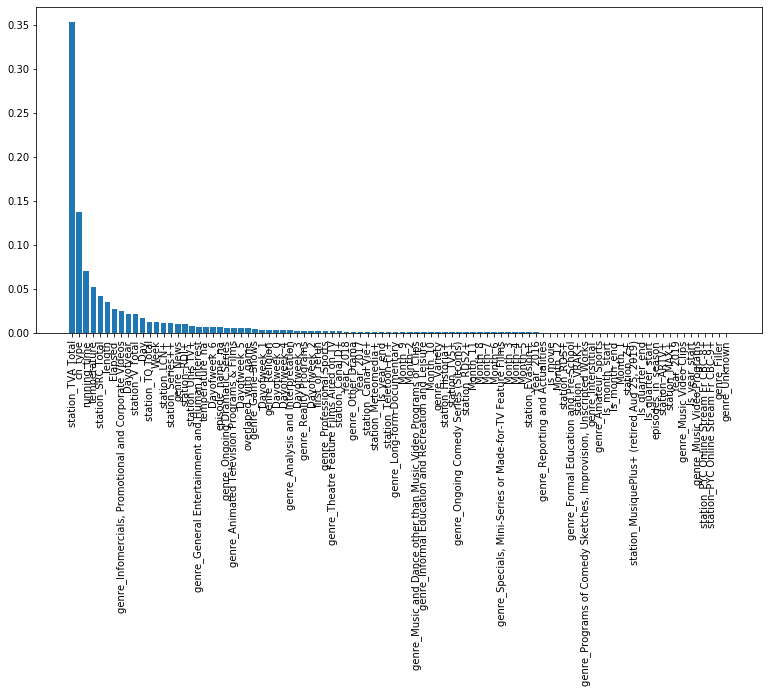

In [0]:
plot_feature_importance(rf.feature_importances_, X_train.columns, figsize=(13, 6))

In [0]:
fi = sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)
to_keep = np.asarray([k for v, k in fi if v > 0.0013])
to_keep = to_keep[:50] if len(to_keep) > 50 else to_keep
print(len(to_keep))

44


In [0]:
to_keep

array(['station_TVA Total', 'ch_type', 'running_time', 'temperature',
       'station_SRC Total', 'length', 'Elapsed',
       'genre_Infomercials, Promotional and Corporate Videos',
       'Dayofyear', 'station_V Total', 'Day', 'station_TQ Total', 'Week',
       'station_LCN+', 'station_Series++', 'genre_News', 'station_RDI+',
       'station_Unis TV+',
       'genre_General Entertainment and Human Interest', 'temperature_na',
       'Dayofweek_6', 'episode_name_na', 'genre_Ongoing Dramatic Series',
       'genre_Animated Television Programs & Films', 'Dayofweek_5',
       'overlaped_with_game', 'genre_Game Shows', 'Dayofweek_1',
       'genre_Religion', 'Dayofweek_0', 'Dayofweek_4',
       'genre_Analysis and Interpretation', 'Dayofweek_3',
       'genre_Reality Programs', 'Dayofweek_2', 'first_or_rerun',
       'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'station_Canal D+',
       'Year_2018', 'genre_Other Drama', 'Year_2017',
       'station_Canal 

In [0]:
%%time

rf2 = get_rf_model()
rf2.fit(X_train[to_keep], y_train)

CPU times: user 6min 24s, sys: 1.76 s, total: 6min 26s
Wall time: 3min 23s


In [0]:
preds_reduced = rf2.predict(X_test[to_keep])
print('oob_score: %.5f' % rf2.oob_score_)
evaluate(y_test, preds_reduced)

oob_score: 0.79130


{'MAE': 1.07021, 'MSE': 3.25003, 'R^2': 0.85873}

In [0]:
# save extracted columns name to diske for later use
np.save(data_dir + '/to_keep_columns_stage1.npy', to_keep)

#### Section Summary:
**Since our model's performance only dropped slightly, keeping 50 most important features is good enough to continue.**

## 2. Hierarical Clustering Analysis (Pairwise Correlations)

In [18]:
to_keep = np.load(data_dir + '/to_keep_columns_stage1.npy')
to_keep.shape

(44,)

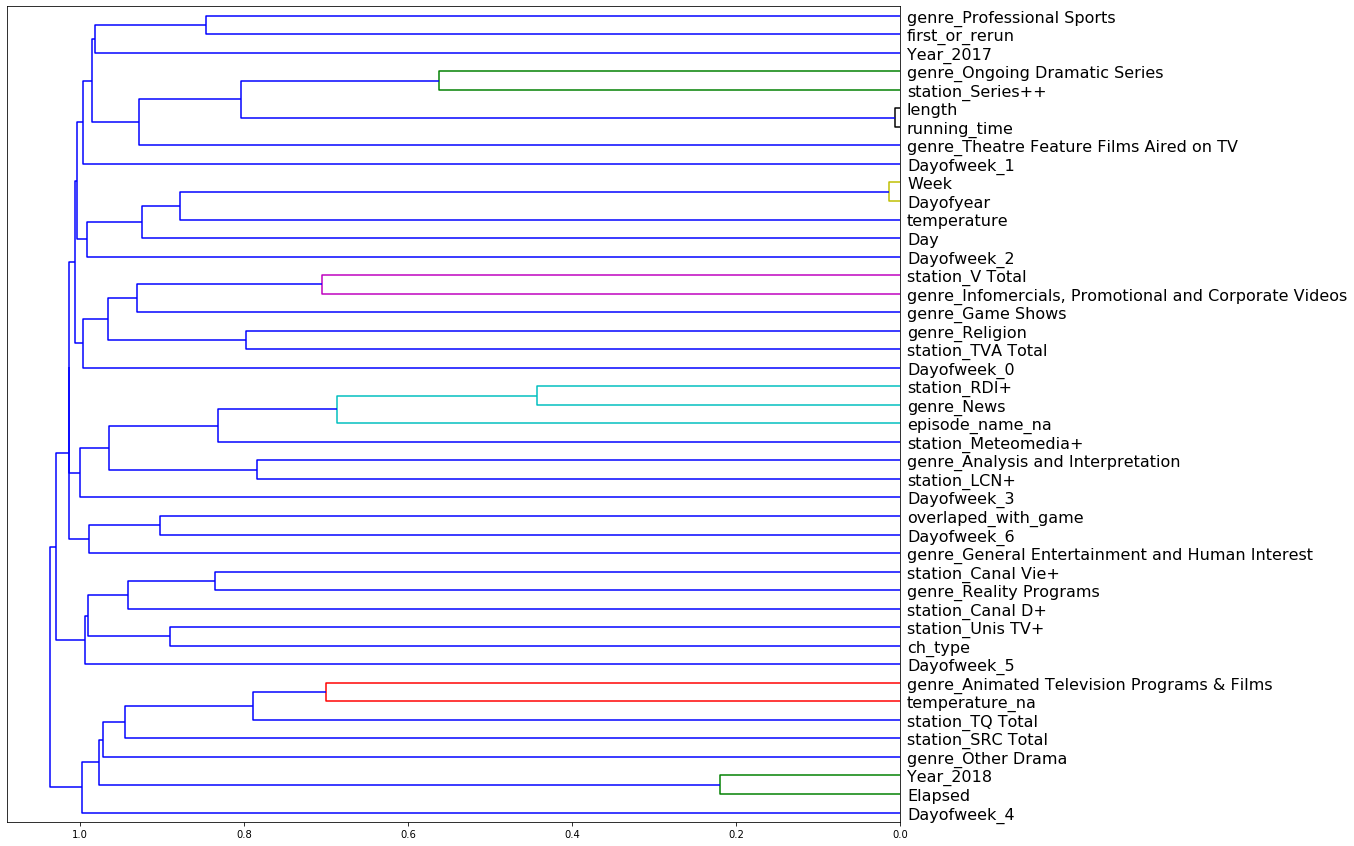

In [19]:
corr = np.round(stats.spearmanr(X_train[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
Z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 15))
dendrogram = hc.dendrogram(Z, labels=X_train[to_keep].columns, orientation='left', leaf_font_size=16)
plt.show()

In [20]:
%%time
# evaluating model's performance with extracted columns -- (for reference only)
full_eval(get_rf_model(), X_train[to_keep], y_train, X_test[to_keep], y_test)

CPU times: user 7min 55s, sys: 1.36 s, total: 7min 56s
Wall time: 4min 9s


{'MAE': 1.07267, 'MSE': 3.60339, 'R^2': 0.84976, 'oob_score': 0.79246}

In [0]:
# removing 'length' feature
to_keep_new = to_keep[to_keep!= 'length']

In [22]:
%%time
# re-evaluating model's performance after dropping 'length' feature
full_eval(get_rf_model(), X_train[to_keep_new], y_train, X_test[to_keep_new], y_test)

CPU times: user 7min 15s, sys: 876 ms, total: 7min 16s
Wall time: 3min 49s


{'MAE': 1.07558, 'MSE': 3.60496, 'R^2': 0.84969, 'oob_score': 0.79273}

In [0]:
np.save(data_dir + '/to_keep_columns_stage2.npy', to_keep_new)

#### Section Summary:
**Based on above dendrogram plot, the only two related features are _running_time_ and _length_ and we tested that removing _length_ feature didn't drop our model's performance.**

## 3. Drop `Year_*` Features

**The training set keeps samples from year 2016 to early 2019 but test set samples are from year 2019. So, keeping year related features like `Year_2016` don't help our model to learn.**

In [29]:
to_keep = np.load(data_dir + '/to_keep_columns_stage2.npy')
to_keep.shape

(43,)

In [30]:
col_year = [col for col in to_keep if col.startswith('Year')]
col_year

['Year_2018', 'Year_2017']

In [31]:
%%time

print(full_eval(get_rf_model(),
          X_train.drop(columns=col_year),
          y_train,
          X_test.drop(columns=col_year),
          y_test))

{'MAE': 1.07677, 'MSE': 3.42147, 'R^2': 0.85688, 'oob_score': 0.78963}
CPU times: user 6min 57s, sys: 2.37 s, total: 7min
Wall time: 3min 41s


In [34]:
print(len(to_keep))
to_keep = [col for col in to_keep if col not in col_year]
print(len(to_keep))

43
41


In [0]:
np.save(data_dir + '/to_keep_columns_stage3.npy', to_keep)

## 3. Sparse Features Grouping --- not completed

In [36]:
to_keep = np.load(data_dir + '/to_keep_columns_stage3.npy')
to_keep.shape

(41,)

In [0]:
X_train = X_train[to_keep]
X_test = X_test[to_keep]

In [38]:
%%time

rf = get_rf_model()
rf.fit(X_train, y_train)
preds = rf.predict(X_test)
print('oob_score: %.5f' % rf.oob_score_)
print(evaluate(y_test, preds))

oob_score: 0.78963
{'MAE': 1.07677, 'MSE': 3.42147, 'R^2': 0.85688}
CPU times: user 6min 45s, sys: 680 ms, total: 6min 46s
Wall time: 3min 33s


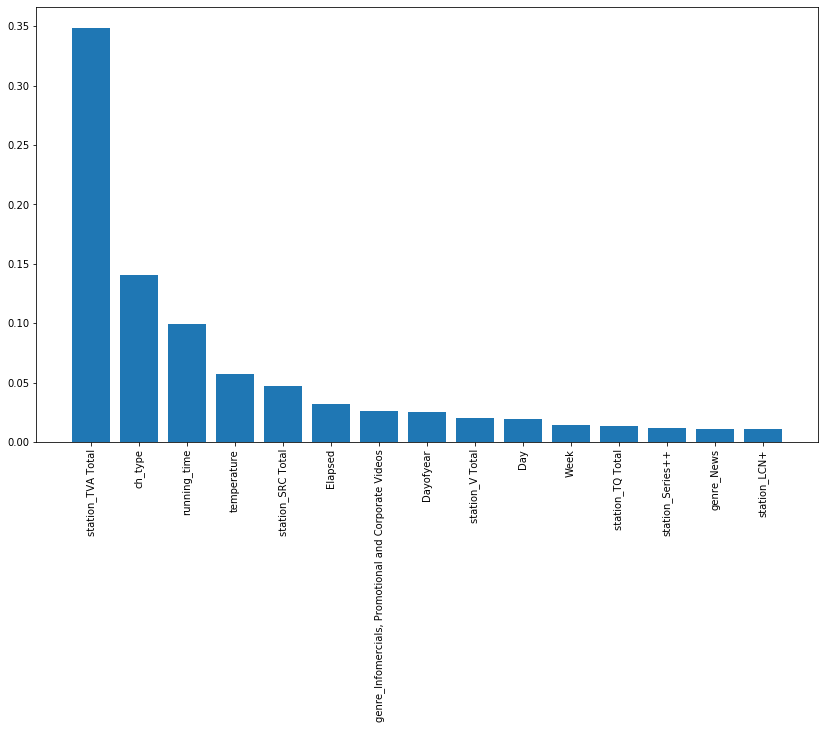

In [39]:
plot_feature_importance(rf.feature_importances_, X_train.columns, n_features=15)

In [40]:
to_keep

array(['station_TVA Total', 'ch_type', 'running_time', 'temperature',
       'station_SRC Total', 'Elapsed',
       'genre_Infomercials, Promotional and Corporate Videos',
       'Dayofyear', 'station_V Total', 'Day', 'station_TQ Total', 'Week',
       'station_LCN+', 'station_Series++', 'genre_News', 'station_RDI+',
       'station_Unis TV+',
       'genre_General Entertainment and Human Interest', 'temperature_na',
       'Dayofweek_6', 'episode_name_na', 'genre_Ongoing Dramatic Series',
       'genre_Animated Television Programs & Films', 'Dayofweek_5',
       'overlaped_with_game', 'genre_Game Shows', 'Dayofweek_1',
       'genre_Religion', 'Dayofweek_0', 'Dayofweek_4',
       'genre_Analysis and Interpretation', 'Dayofweek_3',
       'genre_Reality Programs', 'Dayofweek_2', 'first_or_rerun',
       'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'station_Canal D+',
       'genre_Other Drama', 'station_Canal Vie+', 'station_Meteomedia+'],
      dtype=

**It looks like lots of features in our `to_keep` list are `station`, `genre`, `Dayofweek` and `Month` related**

In [42]:
col_stations = np.asarray([col for col in to_keep if col.startswith('station')])
col_genres = np.asarray([col for col in to_keep if col.startswith('genre')])
col_weekday = np.asarray([col for col in to_keep if col.startswith('Dayofweek')])
# col_months = np.asarray([col for col in to_keep if col.startswith('Month')])


print(f'Stations: {len(col_stations)}')
print(f'Genres: {len(col_genres)}')
print(f'Days of Week: {len(col_weekday)}')
# print(f'Months: {len(col_months)}')

Stations: 11
Genres: 12
Days of Week: 7


### - `Dayofweek_*` features

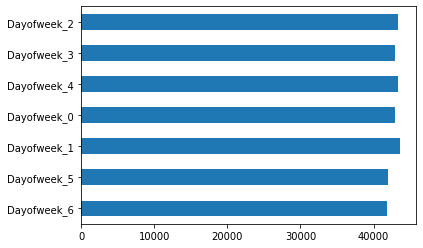

In [43]:
X_train[col_weekday].sum().plot(kind='barh')

In [44]:
X_train[col_weekday].var()

Dayofweek_6    0.119838
Dayofweek_5    0.120424
Dayofweek_1    0.124207
Dayofweek_0    0.122658
Dayofweek_4    0.123691
Dayofweek_3    0.122716
Dayofweek_2    0.123577
dtype: float64

**Amount of variation in different days of the week are roughly equal, so we keep the first 3 more important days and combine the rest.**

In [45]:
col_weekday_keep = col_weekday[:3]
col_weekday_comb = col_weekday[3:]
col_weekday_keep, col_weekday_comb

(array(['Dayofweek_6', 'Dayofweek_5', 'Dayofweek_1'], dtype='<U11'),
 array(['Dayofweek_0', 'Dayofweek_4', 'Dayofweek_3', 'Dayofweek_2'],
       dtype='<U11'))

In [46]:
X_train.shape, X_test.shape

((300000, 41), (35000, 41))

In [0]:
X_train_weekday = X_train.copy()
X_test_weekday = X_test.copy()

In [0]:
def combine_weekday(row, weekdays):
    if row[weekdays].sum() >= 1:
        return 1
    return 0

In [0]:
X_train_weekday['Dayofweek_other'] = X_train_weekday.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)
X_test_weekday['Dayofweek_other'] = X_test_weekday.apply(lambda x: combine_weekday(x, col_weekday_comb), axis=1)

In [50]:
X_train_weekday.drop(columns=col_weekday_comb, inplace=True)
X_test_weekday.drop(columns=col_weekday_comb, inplace=True)

X_train_weekday.shape, X_test_weekday.shape

((300000, 38), (35000, 38))

In [51]:
%%time

rf = get_rf_model()
rf.fit(X_train_weekday, y_train)
preds = rf.predict(X_test_weekday)
print('oob_score: %.5f' % rf.oob_score_)
print(evaluate(y_test, preds))

oob_score: 0.78585
{'MAE': 1.08144, 'MSE': 3.46065, 'R^2': 0.85524}
CPU times: user 6min 14s, sys: 575 ms, total: 6min 14s
Wall time: 3min 17s


In [0]:
# Previous performance:
# {'MAE': 1.07677, 'MSE': 3.42147, 'R^2': 0.85688, oob_score: 0.78963}

### - `genre_*` features

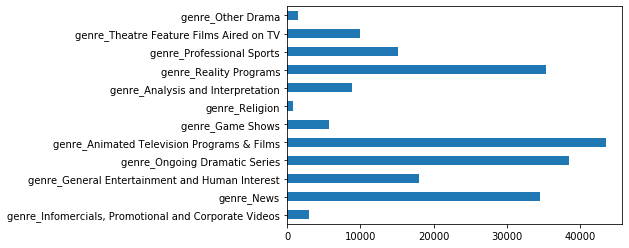

In [52]:
X_train[col_genres].sum().plot.barh()
plt.show()

In [53]:
col_genres

array(['genre_Infomercials, Promotional and Corporate Videos',
       'genre_News', 'genre_General Entertainment and Human Interest',
       'genre_Ongoing Dramatic Series',
       'genre_Animated Television Programs & Films', 'genre_Game Shows',
       'genre_Religion', 'genre_Analysis and Interpretation',
       'genre_Reality Programs', 'genre_Professional Sports',
       'genre_Theatre Feature Films Aired on TV', 'genre_Other Drama'],
      dtype='<U52')

In [0]:
genres_comb = ['genre_Infomercials, Promotional and Corporate Videos', 'genre_Religion', 'genre_Other Drama']

In [0]:
def combine_genres(row, genres):
    if row[genres].sum() >= 1:
        return 1
    return 0

In [56]:
X_train_genre = X_train_weekday.copy()
X_test_genre = X_test_weekday.copy()

X_train_genre.shape, X_test_genre.shape

((300000, 38), (35000, 38))

In [0]:
X_train_genre['genre_comb'] = X_train_genre.apply(lambda x: combine_genres(x, genres_comb), axis=1)
X_test_genre['genre_comb'] = X_test_genre.apply(lambda x: combine_genres(x, genres_comb), axis=1)

X_train_genre.drop(columns=genres_comb, inplace=True)
X_test_genre.drop(columns=genres_comb, inplace=True)

In [58]:
X_train_genre.shape, X_test_genre.shape

((300000, 36), (35000, 36))

In [59]:
%%time

rf = get_rf_model()
print(full_eval(rf, X_train_genre, y_train, X_test_genre, y_test))

{'MAE': 1.08137, 'MSE': 3.46842, 'R^2': 0.85491, 'oob_score': 0.78466}
CPU times: user 6min 28s, sys: 1.16 s, total: 6min 30s
Wall time: 3min 25s


In [0]:
# Previous Performance:
# {'MAE': 1.08144, 'MSE': 3.46065, 'R^2': 0.85524, oob_score: 0.78585}

### - `station_*` features

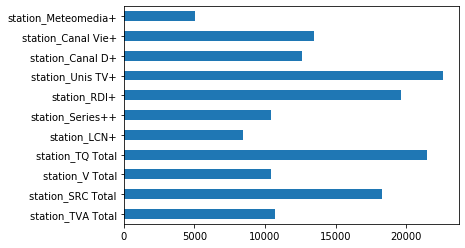

In [61]:
X_train[col_stations].sum().plot(kind='barh')
plt.show()

In [0]:
col_stations_keep = col_stations[:6]
col_stations_comb = col_stations[6:]

In [75]:
X_train_station = X_train_genre.copy()
X_test_station = X_test_genre.copy()

X_train_station.shape, X_test_station.shape

((300000, 36), (35000, 36))

In [0]:
def combine_stations(row, stations):
    if row[stations].sum() >= 1:
        return 1
    return 0

In [78]:
X_train_station['station_comb'] = X_train_station.apply(lambda x: combine_stations(x, col_stations_comb), axis=1)
X_test_station['station_comb'] = X_test_station.apply(lambda x: combine_stations(x, col_stations_comb), axis=1)

X_train_station.drop(columns=col_stations_comb, inplace=True)
X_test_station.drop(columns=col_stations_comb, inplace=True)

X_train_station.shape, X_test_station.shape

((300000, 32), (35000, 32))

In [80]:
%%time

rf = get_rf_model()
print(full_eval(rf, X_train_station, y_train, X_test_station, y_test))

{'MAE': 1.1039, 'MSE': 3.51775, 'R^2': 0.85285, 'oob_score': 0.78194}
CPU times: user 5min 40s, sys: 1.19 s, total: 5min 41s
Wall time: 3min


In [0]:
# {'MAE': 1.08137, 'MSE': 3.46842, 'R^2': 0.85491, 'oob_score': 0.78466}

### -. PCA --- not completed

In [0]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

X_train = X_train_station.copy()
X_test = X_test_station.copy()

In [82]:
pca = PCA(n_components=None)
pca.fit(X=X_train.values)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
pca_var = pca.explained_variance_ratio_

In [108]:
print(len(pca_var))
pca_var[:28].sum()

32


0.998587191720954

In [0]:
pca = PCA(n_components=28)

In [110]:
X_train_pca = pca.fit_transform(X=X_train.values)
X_test_pca = pca.transform(X=X_test.values)

X_train_pca.shape, X_test_pca.shape

((300000, 28), (35000, 28))

In [111]:
%%time

rf = get_rf_model()
print(full_eval(rf, X_train_pca, y_train, X_test_pca, y_test))

{'MAE': 1.12677, 'MSE': 4.02444, 'R^2': 0.83165, 'oob_score': 0.72772}
CPU times: user 38min 2s, sys: 1.15 s, total: 38min 3s
Wall time: 19min 27s


In [0]:
# Previous Performance
# {'MAE': 1.1039, 'MSE': 3.51775, 'R^2': 0.85285, 'oob_score': 0.78194}

## -. SparsePCA --- not completed

In [0]:
spca = SparsePCA(n_components=10, random_state=rs)

In [0]:
X_train_sdr = spca.fit_transform(X=X_train.values)
X_test_sdr = spca.transform(X=X_test.values)

In [0]:
X_train.shape, X_train_sdr.shape

((493324, 91), (493324, 10))

In [0]:
# instantiate a RandomForestRegressor object using the researched hyper-parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=30, n_jobs=-1, random_state=rs)

In [0]:
%%time
# training the RandomForest model with non-transformed y values
print(time.ctime())
rf.fit(X_train_sdr, y_train.iloc[:, 1].values)

Sat Feb 22 01:46:18 2020
Wall time: 5min 27s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [0]:
# top 10 most important features for the RandomForest model
sorted(zip(rf.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.4553702704232678, 'temperature'),
 (0.19889021036921006, 'ch_type'),
 (0.102520397123655, 'overlaped_with_game'),
 (0.06183333057032992, 'is_movie'),
 (0.052246417659769624, 'Is_month_end'),
 (0.034886186825477845, 'first_or_rerun'),
 (0.028156347711736685, 'episodes_in_season'),
 (0.02420950418344279, 'length'),
 (0.02207324690571624, 'Is_quarter_end'),
 (0.019814088227394017, 'Is_month_start')]

In [0]:
# make predictions
rf_preds = rf.predict(X_test_sdr)

In [0]:
# evaluating the RandomForest model
evaluate(y_test.iloc[:, 1].values, rf_preds)

{'MAE': 1.2693409352681773,
 'MSE': 4.949469472597897,
 'R^2': 0.7957833184168581}